# Описание проекта

Компания «X такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Инсталлируем необходимые пакеты**

**Установим библиотеку Prophet от Facebook**

In [1]:
pip install fbprophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from fbprophet import Prophet
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit 
from sklearn import metrics
import numpy as np
from sklearn.dummy import DummyRegressor

import time

import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import (
    CollinearityWarning,
    InterpolationWarning,
    MissingDataError,
)

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [3]:

data = pd.read_csv('C:/Users/simmu/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
print(data.info())
display(data.head(10))
data = data.copy()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<AxesSubplot:xlabel='datetime'>

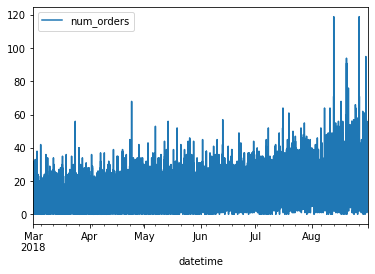

In [4]:
# Построим график до наших преобразований
data.plot()

Итого у нас есть таблица **26496 * 1**. Индексы - это временные моменты, промежутки между которыми равны 10 минут. 

**Сделаем ресемплинг данных по 1 часу**

<AxesSubplot:xlabel='datetime'>

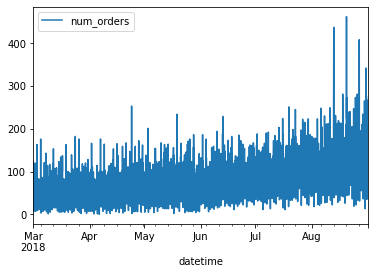

In [5]:
# Сперва отсортируем наш датасет по индексам, затем проведем ресемплинг данных по 1 часу, взяв .sum() в качестве аггрегирующей 
# функции
data_1 = data.sort_index(inplace=True)
data_1 = data.resample('1H').sum()
# Построим график
data_1.plot()

Проверим, является ли наш временной ряд стационарным. По стационарному ряду намного легче делать прогноз, так как его статистические характеристики не меняются и не будут отличаться от текущих. 

**Тест KPSS / проверка временного ряда на стационарность**

* **Нулевая гипотеза**: временной ряд является стационарным
* **Альтернативная гипотеза**: временной ряд не является стационарным.

In [6]:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    
    print(f'KPSS статистика: {statistic}')
    print(f'p-value: {p_value}')
    print(f'количество лагов: {n_lags}')
    print('Критические значения:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Результат: с большой долей вероятности наш временной ряд {"не " if p_value < 0.05 else ""}стационарен')

kpss_test(data_1.num_orders)

KPSS статистика: 11.217516274083737
p-value: 0.01
количество лагов: 31
Критические значения:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Результат: с большой долей вероятности наш временной ряд не стационарен


C:\Users\simmu\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


**p-value вышел равным 0.01**. То есть с высокой степенью вероятности мы отвергаем нулевую гипотезу, то есть с большой долей вероятности **наш временной ряд не стационарен.**

**Разложим временной ряд на тренд и сезонную компоненту, а также остатки**

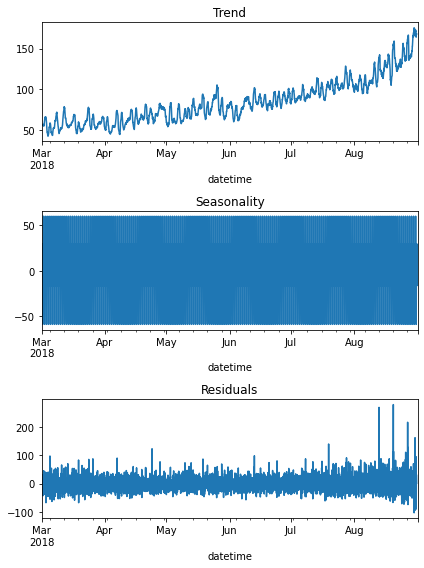

In [7]:
decomposed = seasonal_decompose(data_1) 

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Мы видим тренд в наших данных. График сезонности перестроим и рассмотрим отдельно. 

Text(0.5, 1.0, 'Seasonality')

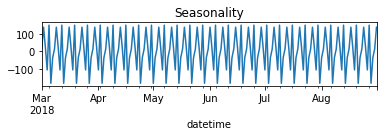

In [8]:
data_2 = data.sort_index()
data_2 = data.resample('1D').sum()
decomposed = seasonal_decompose(data_2)

plt.subplot(312)
decomposed.seasonal.plot()# < напишите код здесь >
plt.title('Seasonality')

* Посмотрим на сезонность в разрезе 1 месяца

Text(0.5, 1.0, 'Seasonality')

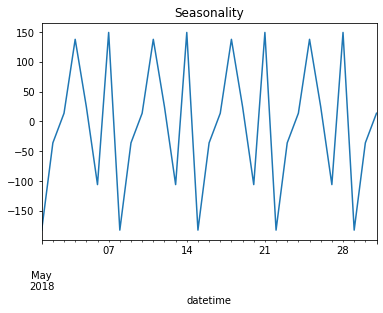

In [9]:
data_2 = data.sort_index()
data_2 = data.resample('1D').sum()
decomposed = seasonal_decompose(data_2)

decomposed.seasonal['2018-05':'2018-05'].plot()
plt.title('Seasonality')

Сезонность различается на графике отчетливо. Паттерн повторяется примерно каждую неделю. 
Мы наблюдаем два "пика" и "провалы". Провалы стабильно приходятся на вторники и воскресенья. 

<AxesSubplot:xlabel='datetime'>

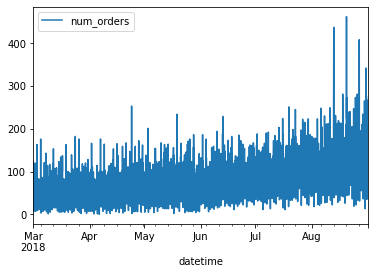

In [10]:
#data_1['rolling_mean'] = data_1.rolling(50).mean()
data_1.plot()

## Создание фичей и обучение моделей

**Добавим такие факторы, как:**
* Фактор час, т.к. есть часовая (суточная) сезонность;
* Фактор день недели, т.к. у нас есть недельная сезонность;
* Фактор, является ли день выходным;
* Фактор lag: это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние;
* Фактор номер недели в году;
* Фактор rolling: чем больше окно сглаживания, тем ровнее линия тренда.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.weekday.isin([5,6])*1
    data['weekofyear'] = data.index.weekofyear
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data_1, 50, 7)

train, test = train_test_split(data_1, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Линейная регрессия

In [12]:
split_index = TimeSeriesSplit().split(features_train)

reg = LinearRegression()

scores = cross_val_score(reg, features_train, target_train, cv=split_index, scoring='neg_mean_squared_error')
print(abs(round(scores.max(), 1)))

466.4


In [13]:
start = time.time()
reg.fit(features_train, target_train)
prediction_train = reg.predict(features_train)


prediction_test = reg.predict(features_test)
rmse_1 = round((mean_squared_error(prediction_test, target_test))**0.5, 1)


In [14]:
print("RMSE тестовой выборки: ", rmse_1)
end = time.time()
time1 = round(end - start, 1)
print(time1)

RMSE тестовой выборки:  42.5
0.0


In [15]:
split_index = TimeSeriesSplit().split(features_train) 


'''params = {
    'n_estimators': [400, 700, 1000],
    'max_depth': [10,15, 20],
    'num_leaves': [25, 50, 100, 150]
}

model = lgb.LGBMRegressor()
gs = GridSearchCV(estimator=model,
                           param_grid=params, cv=split_index, 
                           n_jobs=-1, scoring='neg_mean_squared_error', verbose=3)

model = gs.fit(features_train, target_train)
print(model.best_score_)
print(model.best_params_)'''

"params = {\n    'n_estimators': [400, 700, 1000],\n    'max_depth': [10,15, 20],\n    'num_leaves': [25, 50, 100, 150]\n}\n\nmodel = lgb.LGBMRegressor()\ngs = GridSearchCV(estimator=model,\n                           param_grid=params, cv=split_index, \n                           n_jobs=-1, scoring='neg_mean_squared_error', verbose=3)\n\nmodel = gs.fit(features_train, target_train)\nprint(model.best_score_)\nprint(model.best_params_)"

In [16]:
start = time.time()
model_best = lgb.LGBMRegressor(random_state=15, max_depth=15, n_estimators=700, num_leaves=25)
model_best.fit(features_train, target_train)

LGBMRegressor(max_depth=15, n_estimators=700, num_leaves=25, random_state=15)

In [17]:
predictions = model_best.predict(features_test) 
rmse_2 = round((mean_squared_error(target_test, predictions))**0.5, 1)
print('RMSE:', round(rmse_2, 1))
end = time.time()
time2 = round(end - start, 1)
print(time2)

RMSE: 39.0
0.9


## Библиотека Prophet

In [18]:
data_3 = data.sort_index(inplace=True)
data_3 = data.resample('1H').sum()

display(data_3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


**Разделим наши данные на train и test примерно в соотношении 70% и 30%.** 

In [19]:
split_date = '20-Jul-2018'
train = data_3.loc[data_3.index <= split_date].copy()
test = data_3.loc[data_3.index > split_date].copy()

**Построим график, посмотрим, как на нем будет выглядеть наше разделение**

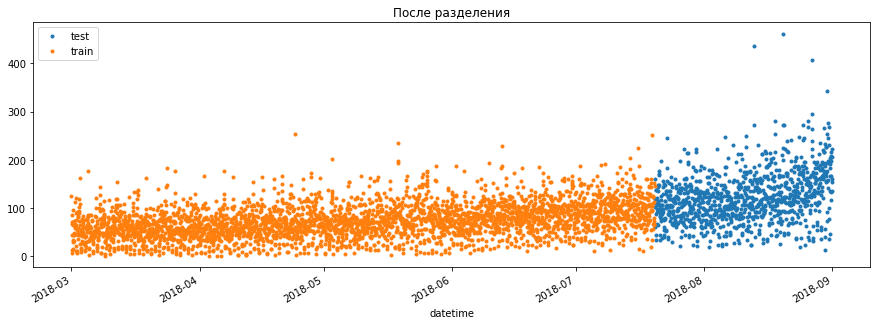

In [20]:
pd.concat([test.rename(columns={'num_orders': 'test'}), train.rename(columns={'num_orders': 'train'})]).plot(figsize=(15,5), title='После разделения', style='.')
plt.show()

**Укажем параметры weekly_seasonality=True, а также учтем календарные праздники с марта по сентябрь 2018 года**

In [21]:
holidays = pd.DataFrame({
  'holiday': 'calendar holidays',
  'ds': pd.to_datetime(['2018-03-08', '2018-05-01', '2018-05-09',
                        '2018-06-12']),
  'lower_window': 0,
  'upper_window': 1,
})

start = time.time()
model = Prophet(weekly_seasonality=True, holidays=holidays)
model.fit(train.reset_index() \
              .rename(columns={'datetime':'ds',
                               'num_orders':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [22]:
test_forecast = model.predict(df=test.reset_index() \
                                   .rename(columns={'datetime':'ds'}))

In [23]:
rmse_3 = round((mean_squared_error(y_true=test['num_orders'],
                   y_pred=test_forecast['yhat']))**0.5, 1)
print('RMSE:', round(rmse_3, 1))
end = time.time()
time3 = round(end - start, 1)
print(time3)

RMSE: 41.8
3.9


Посмотрим, какое значение метрики RMSE мы получим на DummyRegressor

In [24]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
DummyRegressor()
pred = dummy_regr.predict(features_test)

rmse_4 = round((mean_squared_error(target_test,
                   pred))**0.5, 1)

# Вывод

In [25]:
data = {'Алгоритм':['Linear Regression', 'LGBM Regressor','Prophet library', 'Dummy Regressor'],
        'Время обучения модели и предсказания':[time1, time2, time3, "-"],
        'Качество модели (RMSE)':[rmse_1, rmse_2, rmse_3, rmse_4]}
     
models = pd.DataFrame(data=data)
models = models.set_index('Алгоритм')
display(models)

,Время обучения модели и предсказания,Качество модели (RMSE)
Алгоритм,,
Linear Regression,0,42.5
LGBM Regressor,0.9,39.0
Prophet library,3.9,41.8
Dummy Regressor,-,84.6


Самый лучший результат показал **LGBM Regressor со значением метрики качества RMSE 39.**

В заключение посмотрим на график оригинальных тестовых данных и то, что предсказала модель LGBM Regressor

Text(0.5, 1.0, 'Сравнительный график оригинальных тестовых данных и предсказаний модели алгоритма LGBM')

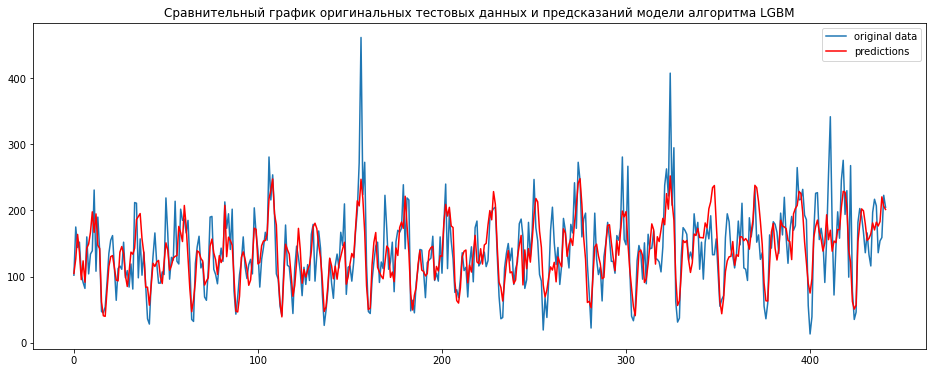

In [26]:
plt.figure(figsize=(16,6))
plt.plot(target_test.values, label = 'original data')
plt.plot(predictions,'r', label = 'predictions')
plt.legend(loc='best')
plt.title('Сравнительный график оригинальных тестовых данных и предсказаний модели алгоритма LGBM')

В целом, график предсказаний неплохо отражает реальную картину с заказами. 